In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
from fastai2.vision.all import *
#import librosa.core
#import librosa.display
import torchaudio
import torchaudio.transforms

In [2]:
path = untar_data('https://storage.googleapis.com/ml-animal-sounds-datasets/macaques_24414Hz.zip')
path

Path('/Users/florian/.fastai/data/macaques_24414Hz')

In [3]:
class TensorAudio(TensorBase):
          
    @classmethod
    def create(cls, o, norm=True):
        o, sr = torchaudio.load(o, normalization=norm)
        #o = cls(tensor(o).float())
        o = cls(o)
        o.sr = sr
        o.mode = 'raw'
        #print(str(sr))
        return o
    '''
    def show(self, ctx=None):
        if self.mode == 'raw':
            print(self.shape)
            librosa.display.waveplot(np.asarray(self.squeeze()), sr=self.sr)
            #print(img.shape)
    '''   

class AudioFixLength(Transform):

    def __init__(self, length=0.0):
        self.length = length

    def encodes(self, o: TensorAudio):
        if self.length > 0.0:
            n_samples = int(o.sr * self.length)
            if n_samples < len(o.squeeze()):
                o = torch.split(o, n_samples, dim=1)[0]
            else:
                n_pad = int(o.sr * self.length - len(o.squeeze()))
                n_pre = (torch.rand(1) * n_pad).int()
                n_post = n_pad - n_pre
                o = F.pad(input=o, pad=(n_pre,n_post), mode='constant', value=0)
        return o
    
class AudioResample(Transform):

    def __init__(self, target_sr=0, device='cpu'):
        self.target_sr = target_sr
        self.device = device

    def encodes(self, o: TensorAudio):
        if self.target_sr != o.sr:
            resample = torchaudio.transforms.Resample(orig_freq=o.sr, new_freq=self.target_sr).to(self.device)
            o = TensorAudio(resample(o))
            o.sr = self.target_sr
        return o
    
'''    
class AudioNormalize(Transform):
    def __init__(self, mean, std, device='cpu'):
        self.mean = mean
        self.std = std
        self.device = device
        
    def encodes(self, o: TensorAudio):
        return ((o - self.mean) / self.std).to(self.device)
'''    
    
class AudioRandomCrop(RandTransform):
    
    def __init__(self, p=1.0, length=0.0): 
        super().__init__(p=p)
        self.length = length
        
    def encodes(self, o: TensorAudio): 
        if length > 0.0:
            n_samples = int(o.sr * self.length)
            if n_samples < len(o[0]):
                n_cut = len(o[0]) - n_samples
                n_pre = (n_cut * torch.rand(1)).int()
                o = o[:,n_pre:(n_samples + n_pre)]
        return o    
    

class AudioAddNoise(RandTransform):
    "Randomly add noise with probability `p`"
    def __init__(self, p=0.5, device='cpu'): 
        super().__init__(p=p)
        self.device=device
        
    def encodes(self, o: TensorAudio): 
        noise_amp = (0.001*torch.rand(1) * torch.max(o)).to(self.device)
        o = (o + noise_amp * torch.empty(o.shape).normal_()).to(self.device)
        return o
    

class AudioToTensor(Transform):

    def encodes(self, o: TensorAudio):
        o = tensor(o).float()
        return o

def AudioBlock(length=0.0):
    return TransformBlock(type_tfms=TensorAudio.create, batch_tfms=AudioToTensor)

In [4]:
length = 0.75
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dblocks = DataBlock(blocks = (AudioBlock,CategoryBlock),
                 get_items=get_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=parent_label,
                 #item_tfms=[AudioFixLength(length=length)],
                 item_tfms=[AudioResample(target_sr=(24414//2), device=device),AudioRandomCrop(length=length),AudioFixLength(length=length)],
                 batch_tfms=[AudioAddNoise(device=device)]
                 )

dls=dblocks.dataloaders(path, bs=128)

In [5]:
dls.one_batch()

(TensorAudio([[[-8.8292e-04, -6.5137e-04,  2.9648e-04,  ...,  7.3863e-04,
            3.0534e-04, -8.3377e-04]],
 
         [[ 1.6149e-04,  1.4158e-04,  8.1214e-04,  ...,  1.0812e-03,
           -2.9238e-05,  4.5770e-04]],
 
         [[-1.7464e-04,  5.7165e-04,  1.4635e-04,  ..., -8.4292e-04,
            1.0908e-03, -8.4615e-07]],
 
         ...,
 
         [[ 1.2391e-05,  4.6973e-04,  4.4479e-04,  ..., -4.4870e-04,
            1.3441e-03, -4.7937e-04]],
 
         [[-7.2211e-04, -6.4759e-05,  3.9771e-04,  ...,  2.1762e-04,
           -1.0909e-03, -6.6489e-04]],
 
         [[-2.8277e-04, -6.0212e-04,  5.9717e-04,  ..., -5.5914e-04,
            3.0306e-04, -8.1990e-04]]]),
 TensorCategory([6, 3, 5, 1, 1, 5, 3, 6, 3, 4, 5, 0, 1, 0, 0, 5, 2, 2, 0, 2, 6, 6, 6, 0,
         3, 6, 5, 5, 4, 2, 2, 2, 3, 3, 2, 4, 5, 3, 3, 2, 1, 2, 2, 7, 6, 6, 6, 1,
         0, 1, 4, 2, 2, 7, 4, 0, 1, 4, 6, 6, 0, 4, 5, 6, 1, 4, 6, 6, 7, 5, 5, 7,
         1, 3, 2, 6, 5, 7, 6, 3, 5, 6, 3, 5, 6, 4, 4, 2, 6, 4, 7, 3,

In [6]:
# https://www.kaggle.com/readilen/resnet-for-mnist-with-pytorch

def conv1xk(in_channels, out_channels, kernel_size=3, stride=1):
    padding = kernel_size // 2
    return nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size,
                    stride=stride, padding=padding, bias=False)

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv1xk(in_channels, out_channels, kernel_size, stride)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv1xk(out_channels, out_channels, kernel_size)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        #print("in", x.shape)
        residual = x
        out = self.conv1(x)
        #print("conv1", out.shape)
        out = self.bn1(out)
        #print("bn1", out.shape)
        out = self.relu(out)
        out = self.conv2(out)
        #print("conv2", out.shape)
        out = self.bn2(out)
        #print("bn2", out.shape)
        if self.downsample:
            #print("downsample")
            residual = self.downsample(residual)
        #print("+", out.shape, residual.shape)
        out += residual
        out = self.relu(out)
        return out
    
# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10, kernel_size=3, stride=2):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv1xk(1, 16)
        self.bn = nn.BatchNorm1d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0], kernel_size)
        self.layer2 = self.make_layer(block, 32, layers[0], kernel_size, stride)
        self.layer3 = self.make_layer(block, 64, layers[1], kernel_size, stride)
        self.layer4 = self.make_layer(block, 128, layers[2], kernel_size, stride)
        self.layer5 = self.make_layer(block, 256, layers[3], kernel_size, stride)
        self.layer6 = self.make_layer(block, 512, layers[4], kernel_size, stride)
        self.avg_pool = nn.AvgPool1d(8)
        self.fc1 = nn.Linear(512, 48)
        self.fc2 = nn.Linear(48, num_classes)

    def make_layer(self, block, out_channels, blocks, kernel_size=3, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv1xk (self.in_channels, out_channels, kernel_size=kernel_size, stride=stride),
                nn.BatchNorm1d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, kernel_size, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [7]:
kernel_size = 15
stride = 4

net_args = {
    "block": ResidualBlock,
    "layers": [2, 2, 2, 2, 2, 2],
    "kernel_size": kernel_size,
    "stride": stride,
    "num_classes": 8
}
model = ResNet(**net_args)

In [8]:
learn = Learner(dls, model, loss_func=F.cross_entropy, metrics=accuracy, cbs=ShowGraphCallback())

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,1.509471,1.720190,0.353466,00:09
1,1.084013,0.700926,0.783802,00:08
2,0.707794,0.419722,0.864791,00:08
3,0.497422,0.331888,0.873027,00:08
4,0.365117,0.342985,0.880577,00:08
5,0.297561,0.464450,0.860673,00:08
6,0.270984,0.260626,0.905971,00:08
7,0.239630,0.273329,0.906658,00:08
8,0.210055,0.319008,0.900480,00:08
9,0.192909,0.225371,0.929307,00:08


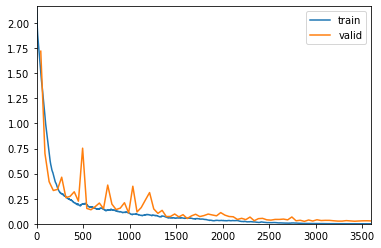

In [12]:
learn.unfreeze()
learn.fit_one_cycle(80, 3e-4)